# Baseline model - historical averages 

This notebook uses simple historical averages to make predictions, such as rolling mean (previous 7 days), seasonal mean, weekend mean, holiday mean, and Kieler Woche mean. 

* Rolling Mean Model: Predicts based on the last available 7-day rolling average for each product category.

* Seasonal Mean: Predicts today’s sales as the sales from the same day last week.

* Weekend Mean: Predicts sales as the average for weekends or weekdays.

* Holiday Mean: Predicts sales as the average for holidays.

* Kieler Woche: 

# Import library and data 

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Load data 
df = pd.read_csv("prepared_sales_weather_event_data.csv", parse_dates=["Datum"])


# clean data 

In [96]:
# Sort by date for consistency 
df = df.sort_values("Datum").reset_index(drop=True)  

# Drop missing sales or category values 
df = df.dropna(subset=["Umsatz", "Warengruppe", "TemperatureCategory", "CloudCategory", "WindCategory","Season", "IsHoliday_lib"])  

# Create weekend indicator 
df['IsWeekend'] = df['Datum'].dt.dayofweek.isin([5, 6]).astype(int)  

# Check data date range first 
print(f"Data date range: {df['Datum'].min()} to {df['Datum'].max()}") 
print(f"Total records: {len(df)}")  

Data date range: 2013-07-01 00:00:00 to 2018-07-31 00:00:00
Total records: 9264


# Split data 

Split into 70% train, 20% val, 10% test

In [97]:

# Split data based on actual date range - 70% train, 20% val, 10% test
df_sorted = df.sort_values('Datum').reset_index(drop=True)
n_total = len(df_sorted)

# Calculate split indices
train_idx = int(0.70 * n_total)
val_idx = int(0.90 * n_total)  # 70% + 20% = 90%

# Split the data
train_data = df_sorted.iloc[:train_idx].copy()
val_data = df_sorted.iloc[train_idx:val_idx].copy()
test_data = df_sorted.iloc[val_idx:].copy()

print(f"\nTraining data: {len(train_data)} records ({train_data['Datum'].min()} to {train_data['Datum'].max()})")
print(f"Validation data: {len(val_data)} records ({val_data['Datum'].min()} to {val_data['Datum'].max()})")
print(f"Test data: {len(test_data)} records ({test_data['Datum'].min()} to {test_data['Datum'].max()})")

# Verify we have data in all splits
if len(train_data) == 0:
    raise ValueError("No training data found!")
if len(val_data) == 0:
    raise ValueError("No validation data found!")
if len(test_data) == 0:
    raise ValueError("No test data found!")



Training data: 6484 records (2013-07-01 00:00:00 to 2017-01-09 00:00:00)
Validation data: 1853 records (2017-01-09 00:00:00 to 2018-01-24 00:00:00)
Test data: 927 records (2018-01-24 00:00:00 to 2018-07-31 00:00:00)


# Create baseline model 

5 Baseline models:

1. Rolling Mean Baseline Model - Uses only 7-day rolling averages
    * Predicts based on the last available 7-day rolling average for each product category.
2. Seasonal Baseline Model - Uses only seasonal means (Spring, Summer, Fall, Winter)
    * Predicts based on the historical average sales for the current season.
3. Weekend Baseline Model - Uses only weekend vs. weekday means
    * Predicts based on whether it's a weekend or weekday.
4. Holiday Baseline Model - Uses only holiday vs. non-holiday means
    * Predicts based on whether it's a holiday or not.
5. Kieler Woche Baseline Model - Uses only Kieler Woche event means
    * Predicts based on whether it's during the Kieler Woche event period.

In [98]:

# Get unique product categories
categories = sorted(df['Warengruppe'].unique())
category_names = {1: 'Brot', 2: 'Brötchen', 3: 'Croissant', 4: 'Konditorei', 5: 'Kuchen', 6: 'Saisonbrot'}
print(f"\nProduct categories: {categories}")

class RollingMeanBaselineModel:
    """Baseline model using only 7-day rolling mean - FIXED VERSION"""
    def __init__(self):
        self.rolling_means = {}
        self.category_names = {1: 'Brot', 2: 'Brötchen', 3: 'Croissant', 4: 'Konditorei', 5: 'Kuchen', 6: 'Saisonbrot'}
    
    def fit(self, train_data):
        """Fit the rolling mean baseline model"""
        print("Training Rolling Mean baseline model...")
        
        for category in categories:
            cat_data = train_data[train_data['Warengruppe'] == category].copy()
            cat_data = cat_data.sort_values('Datum').reset_index(drop=True)
            
            if len(cat_data) >= 7:
                rolling_mean = cat_data['Umsatz'].rolling(window=7, min_periods=1).mean().iloc[-1]
                self.rolling_means[category] = rolling_mean
            else:
                self.rolling_means[category] = cat_data['Umsatz'].mean() if len(cat_data) > 0 else 0
        
        print("Rolling Mean baseline model training completed!")
        print(f"Learned rolling means: {self.rolling_means}")
    
    def predict(self, test_data):
        """Make predictions using only the last rolling mean from training"""
        predictions = []
        
        for idx, row in test_data.iterrows():
            category = row['Warengruppe']
            prediction = self.rolling_means.get(category, 0)
            predictions.append(max(0, prediction))
        
        return np.array(predictions)

class SeasonalBaselineModel:
    """Baseline model using only seasonal means - FIXED VERSION"""
    def __init__(self):
        self.seasonal_means = {}
        self.category_names = {1: 'Brot', 2: 'Brötchen', 3: 'Croissant', 4: 'Konditorei', 5: 'Kuchen', 6: 'Saisonbrot'}
    
    def fit(self, train_data):
        """Fit the seasonal baseline model"""
        print("Training Seasonal baseline model...")
        
        for category in categories:
            cat_data = train_data[train_data['Warengruppe'] == category].copy()
            
            if len(cat_data) > 0:
                season_means = cat_data.groupby('Season')['Umsatz'].mean().to_dict()
                self.seasonal_means[category] = season_means
            else:
                self.seasonal_means[category] = {}
        
        print("Seasonal baseline model training completed!")
        print(f"Learned seasonal patterns: {self.seasonal_means}")
    
    def predict(self, test_data):
        """Make predictions using seasonal means from training data"""
        predictions = []
        
        for idx, row in test_data.iterrows():
            category = row['Warengruppe']
            season = row['Season']
            
            if category in self.seasonal_means:
                prediction = self.seasonal_means[category].get(season, 0)
            else:
                prediction = 0
                
            predictions.append(max(0, prediction))
        
        return np.array(predictions)

class WeekendBaselineModel:
    """Baseline model using only weekend means - FIXED VERSION"""
    def __init__(self):
        self.weekend_means = {}
        self.category_names = {1: 'Brot', 2: 'Brötchen', 3: 'Croissant', 4: 'Konditorei', 5: 'Kuchen', 6: 'Saisonbrot'}
    
    def fit(self, train_data):
        """Fit the weekend baseline model"""
        print("Training Weekend baseline model...")
        
        for category in categories:
            cat_data = train_data[train_data['Warengruppe'] == category].copy()
            
            if len(cat_data) > 0:
                weekend_means = cat_data.groupby('IsWeekend')['Umsatz'].mean().to_dict()
                self.weekend_means[category] = weekend_means
            else:
                self.weekend_means[category] = {}
        
        print("Weekend baseline model training completed!")
        print(f"Learned weekend patterns: {self.weekend_means}")
    
    def predict(self, test_data):
        """Make predictions using weekend means from training data"""
        predictions = []
        
        for idx, row in test_data.iterrows():
            category = row['Warengruppe']
            is_weekend = row['IsWeekend']
            
            if category in self.weekend_means:
                prediction = self.weekend_means[category].get(is_weekend, 0)
            else:
                prediction = 0
                
            predictions.append(max(0, prediction))
        
        return np.array(predictions)

class HolidayBaselineModel:
    """Baseline model using only holiday means - FIXED VERSION"""
    def __init__(self):
        self.holiday_means = {}
        self.category_names = {1: 'Brot', 2: 'Brötchen', 3: 'Croissant', 4: 'Konditorei', 5: 'Kuchen', 6: 'Saisonbrot'}
    
    def fit(self, train_data):
        """Fit the holiday baseline model"""
        print("Training Holiday baseline model...")
        
        for category in categories:
            cat_data = train_data[train_data['Warengruppe'] == category].copy()
            
            if len(cat_data) > 0:
                holiday_means = cat_data.groupby('IsHoliday_lib')['Umsatz'].mean().to_dict()
                self.holiday_means[category] = holiday_means
            else:
                self.holiday_means[category] = {}
        
        print("Holiday baseline model training completed!")
        print(f"Learned holiday patterns: {self.holiday_means}")
    
    def predict(self, test_data):
        """Make predictions using holiday means from training data"""
        predictions = []
        
        for idx, row in test_data.iterrows():
            category = row['Warengruppe']
            is_holiday = row['IsHoliday_lib']
            
            if category in self.holiday_means:
                prediction = self.holiday_means[category].get(is_holiday, 0)
            else:
                prediction = 0
                
            predictions.append(max(0, prediction))
        
        return np.array(predictions)

class KielerWocheBaselineModel:
    """Baseline model using only Kieler Woche means - FIXED VERSION"""
    def __init__(self):
        self.kw_means = {}
        self.category_names = {1: 'Brot', 2: 'Brötchen', 3: 'Croissant', 4: 'Konditorei', 5: 'Kuchen', 6: 'Saisonbrot'}
    
    def fit(self, train_data):
        """Fit the Kieler Woche baseline model"""
        print("Training Kieler Woche baseline model...")
        
        for category in categories:
            cat_data = train_data[train_data['Warengruppe'] == category].copy()
            
            if len(cat_data) > 0:
                kw_means = cat_data.groupby('KielerWoche')['Umsatz'].mean().to_dict()
                self.kw_means[category] = kw_means
            else:
                self.kw_means[category] = {}
        
        print("Kieler Woche baseline model training completed!")
        print(f"Learned Kieler Woche patterns: {self.kw_means}")
    
    def predict(self, test_data):
        """Make predictions using Kieler Woche means from training data"""
        predictions = []
        
        for idx, row in test_data.iterrows():
            category = row['Warengruppe']
            is_kw = row['KielerWoche']
            
            if category in self.kw_means:
                prediction = self.kw_means[category].get(is_kw, 0)
            else:
                prediction = 0
                
            predictions.append(max(0, prediction))
        
        return np.array(predictions)

# Initialize and train all baseline models
print("\n" + "="*80)
print("TRAINING SEPARATE BASELINE MODELS - FIXED VERSION")
print("="*80)

rolling_model = RollingMeanBaselineModel()
seasonal_model = SeasonalBaselineModel()
weekend_model = WeekendBaselineModel()
holiday_model = HolidayBaselineModel()
kw_model = KielerWocheBaselineModel()

# Train all models
rolling_model.fit(train_data)
seasonal_model.fit(train_data)
weekend_model.fit(train_data)
holiday_model.fit(train_data)
kw_model.fit(train_data)

# Generate predictions for validation and test sets
print("\nGenerating predictions for all models...")

models = {
    'Rolling Mean (7-day)': rolling_model,
    'Seasonal': seasonal_model,
    'Weekend': weekend_model,
    'Holiday': holiday_model,
    'Kieler Woche': kw_model
}

# Store all predictions
val_predictions_all = {}
test_predictions_all = {}

for model_name, model in models.items():
    print(f"Generating predictions for {model_name} model...")
    val_predictions_all[model_name] = model.predict(val_data)
    test_predictions_all[model_name] = model.predict(test_data)

def calculate_metrics(y_true, y_pred):
    """Calculate evaluation metrics"""
    if len(y_true) == 0 or len(y_pred) == 0:
        return {
            'MAPE': float('nan'),
            'MSE': float('nan'),
            'RMSE': float('nan'),
            'R²': float('nan'),
            'MAE': float('nan')
        }
    
    # Handle zero values for MAPE calculation
    y_true_nonzero = y_true[y_true != 0]
    y_pred_nonzero = y_pred[y_true != 0]
    
    mape = mean_absolute_percentage_error(y_true_nonzero, y_pred_nonzero) * 100 if len(y_true_nonzero) > 0 else float('inf')
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    return {
        'MAPE': mape,
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'R²': r2,
        'MAE': mae
    }

# Evaluate all models
print("\n" + "="*80)
print("MODEL EVALUATION RESULTS")
print("="*80)

val_results = {}
test_results = {}

# Validation set evaluation
print("\nVALIDATION SET RESULTS:")
print("-" * 50)
for model_name in models.keys():
    if len(val_data) > 0:
        metrics = calculate_metrics(val_data['Umsatz'], val_predictions_all[model_name])
        val_results[model_name] = metrics
        print(f"\n{model_name} Model:")
        for metric, value in metrics.items():
            if not np.isnan(value) and not np.isinf(value):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
    else:
        print(f"\n{model_name} Model: No validation data available")

# Test set evaluation
print("\nTEST SET RESULTS:")
print("-" * 50)
for model_name in models.keys():
    if len(test_data) > 0:
        metrics = calculate_metrics(test_data['Umsatz'], test_predictions_all[model_name])
        test_results[model_name] = metrics
        print(f"\n{model_name} Model:")
        for metric, value in metrics.items():
            if not np.isnan(value) and not np.isinf(value):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
    else:
        print(f"\n{model_name} Model: No test data available")

# Enhanced Category-wise performance analysis
def analyze_category_performance_enhanced(data, predictions_dict, dataset_name):
    """Enhanced category performance analysis with comprehensive metrics"""
    
    print(f"\n{dataset_name.upper()} SET - DETAILED CATEGORY PERFORMANCE:")
    print("=" * 80)
    
    category_results = {}
    
    for category in categories:
        cat_data = data[data['Warengruppe'] == category]
        if len(cat_data) > 0:
            print(f"\n{category_names[category]} (Category {category}):")
            print("-" * 50)
            
            category_results[category] = {}
            
            for model_name, predictions in predictions_dict.items():
                cat_predictions = predictions[data['Warengruppe'] == category]
                metrics = calculate_metrics(cat_data['Umsatz'], cat_predictions)
                category_results[category][model_name] = metrics
                
                print(f"\n{model_name}:")
                for metric, value in metrics.items():
                    if not np.isnan(value) and not np.isinf(value):
                        print(f"  {metric}: {value:.4f}")
                    else:
                        print(f"  {metric}: {value}")
    
    return category_results

# Perform enhanced category analysis
cat_val_results = {}
cat_test_results = {}

if len(val_data) > 0:
    cat_val_results = analyze_category_performance_enhanced(val_data, val_predictions_all, "Validation")

if len(test_data) > 0:
    cat_test_results = analyze_category_performance_enhanced(test_data, test_predictions_all, "Test")

# COMPREHENSIVE SUMMARY SECTION
print("\n" + "="*100)
print("COMPREHENSIVE BASELINE MODELS SUMMARY")
print("="*100)

def generate_model_summary(results_dict, dataset_name):
    """Generate comprehensive model summary"""
    
    print(f"\n{dataset_name.upper()} SET MODEL SUMMARY:")
    print("=" * 60)
    
    if not results_dict:
        print(f"No {dataset_name.lower()} results available")
        return
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(results_dict).T
    summary_df = summary_df.round(4)
    
    print("\nDetailed Performance Metrics:")
    print(summary_df)
    
    # Best performing models by metric
    print(f"\nBEST PERFORMING MODELS ({dataset_name} Set):")
    print("-" * 40)
    
    for metric in ['MAPE', 'MSE', 'RMSE', 'MAE']:
        if metric in summary_df.columns:
            valid_results = summary_df[metric].dropna()
            if len(valid_results) > 0:
                if metric == 'R²':
                    best_model = valid_results.idxmax()
                    best_value = valid_results.max()
                else:
                    best_model = valid_results.idxmin()
                    best_value = valid_results.min()
                print(f"Best {metric:4s}: {best_model:20s} ({best_value:.4f})")
    
    # Performance ranking
    print(f"\nMODEL RANKING BY MAPE ({dataset_name} Set):")
    print("-" * 40)
    mape_ranking = summary_df['MAPE'].dropna().sort_values()
    for i, (model, mape) in enumerate(mape_ranking.items(), 1):
        print(f"{i}. {model:20s}: {mape:.2f}%")

def generate_category_summary(cat_results_dict, dataset_name):
    """Generate comprehensive category-wise summary"""
    
    print(f"\n{dataset_name.upper()} SET CATEGORY SUMMARY:")
    print("=" * 60)
    
    if not cat_results_dict:
        print(f"No {dataset_name.lower()} category results available")
        return
    
    # Best model per category
    print(f"\nBEST MODEL PER BAKERY CATEGORY ({dataset_name} Set):")
    print("-" * 50)
    
    for category, model_results in cat_results_dict.items():
        if model_results:
            # Find best model by MAPE
            mape_results = {model: metrics['MAPE'] for model, metrics in model_results.items() 
                          if not np.isnan(metrics['MAPE']) and not np.isinf(metrics['MAPE'])}
            if mape_results:
                best_model = min(mape_results, key=mape_results.get)
                best_mape = mape_results[best_model]
                print(f"{category_names[category]:12s}: {best_model:20s} (MAPE: {best_mape:.2f}%)")
    
    # Category difficulty ranking
    print(f"\nCATEGORY DIFFICULTY RANKING ({dataset_name} Set):")
    print("-" * 50)
    
    category_avg_mape = {}
    for category, model_results in cat_results_dict.items():
        if model_results:
            mape_values = [metrics['MAPE'] for metrics in model_results.values() 
                          if not np.isnan(metrics['MAPE']) and not np.isinf(metrics['MAPE'])]
            if mape_values:
                category_avg_mape[category] = np.mean(mape_values)
    
    sorted_categories = sorted(category_avg_mape.items(), key=lambda x: x[1])
    for i, (category, avg_mape) in enumerate(sorted_categories, 1):
        difficulty = "Easy" if avg_mape < 50 else "Medium" if avg_mape < 100 else "Hard"
        print(f"{i}. {category_names[category]:12s}: {avg_mape:.2f}% (avg) - {difficulty}")

# Generate comprehensive summaries
generate_model_summary(val_results, "Validation")
generate_model_summary(test_results, "Test")

generate_category_summary(cat_val_results, "Validation")
generate_category_summary(cat_test_results, "Test")

# EXECUTIVE SUMMARY
print("\n" + "="*100)
print("EXECUTIVE SUMMARY - BASELINE MODELS ANALYSIS")
print("="*100)

print("\nMODEL ARCHITECTURE SUMMARY:")
print("-" * 40)
print("1. Rolling Mean Model    : Uses 7-day rolling average from training data")
print("2. Seasonal Model        : Uses seasonal patterns (Spring/Summer/Fall/Winter)")
print("3. Weekend Model         : Uses weekday vs weekend patterns")
print("4. Holiday Model         : Uses holiday vs non-holiday patterns")
print("5. Kieler Woche Model    : Uses Kieler Woche event patterns")

print("\nKEY INSIGHTS:")
print("-" * 40)

# Overall best model
if test_results:
    test_mape = {model: metrics['MAPE'] for model, metrics in test_results.items() 
                if not np.isnan(metrics['MAPE']) and not np.isinf(metrics['MAPE'])}
    if test_mape:
        best_overall = min(test_mape, key=test_mape.get)
        best_overall_mape = test_mape[best_overall]
        print(f"• Best Overall Model: {best_overall} (MAPE: {best_overall_mape:.2f}%)")

# Model complexity vs performance
print("• Model Complexity: All models use simple statistical patterns")
print("• Data Leakage: FIXED - Models use only training data patterns")
print("• Prediction Consistency: Each model provides unique predictions")

print("\nRecommendations:")
print("-" * 40)
print("• Consider ensemble methods combining multiple baseline models")
print("• Investigate category-specific model selection")
print("• Evaluate advanced time series models (ARIMA, Prophet, LSTM)")
print("• Implement feature engineering for better pattern capture")

# Debug verification
print("\n" + "="*80)
print("DEBUG VERIFICATION - ENSURING NO DATA LEAKAGE")
print("="*80)

for model_name, predictions in val_predictions_all.items():
    unique_preds = len(np.unique(predictions))
    print(f"{model_name:20s}: {unique_preds:3d} unique predictions")
    
    # Show first few predictions vs actual
    print(f"  Sample - Actual: {val_data['Umsatz'].head(5).values}")
    print(f"  Sample - Predicted: {predictions[:5]}")

print("\nVerification Complete: All models show distinct prediction patterns")
print("=" * 80)


Product categories: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0)]

TRAINING SEPARATE BASELINE MODELS - FIXED VERSION
Training Rolling Mean baseline model...
Rolling Mean baseline model training completed!
Learned rolling means: {np.float64(1.0): np.float64(95.46069681311965), np.float64(2.0): np.float64(297.44977157136674), np.float64(3.0): np.float64(90.14348365804334), np.float64(4.0): np.float64(94.99127370907705), np.float64(5.0): np.float64(275.22343602274947), np.float64(6.0): np.float64(60.48124657690213)}
Training Seasonal baseline model...
Seasonal baseline model training completed!
Learned seasonal patterns: {np.float64(1.0): {'Autumn': 118.69779373604885, 'Spring': 120.36505348060743, 'Summer': 136.9765480534524, 'Winter': 110.84804344235505}, np.float64(2.0): {'Autumn': 383.5358699080748, 'Spring': 388.2461236875822, 'Summer': 552.3413231424685, 'Winter': 336.4668244041541}, np.float64(3.0): {'Autumn': 154.0610869831

# Plots 

Visual comparison of actual vs predicted values of the 5 models. 


GENERATING VISUALIZATION PLOTS
Generating comprehensive comparison plots...
1. Creating Actual vs Predicted plots for Validation set...


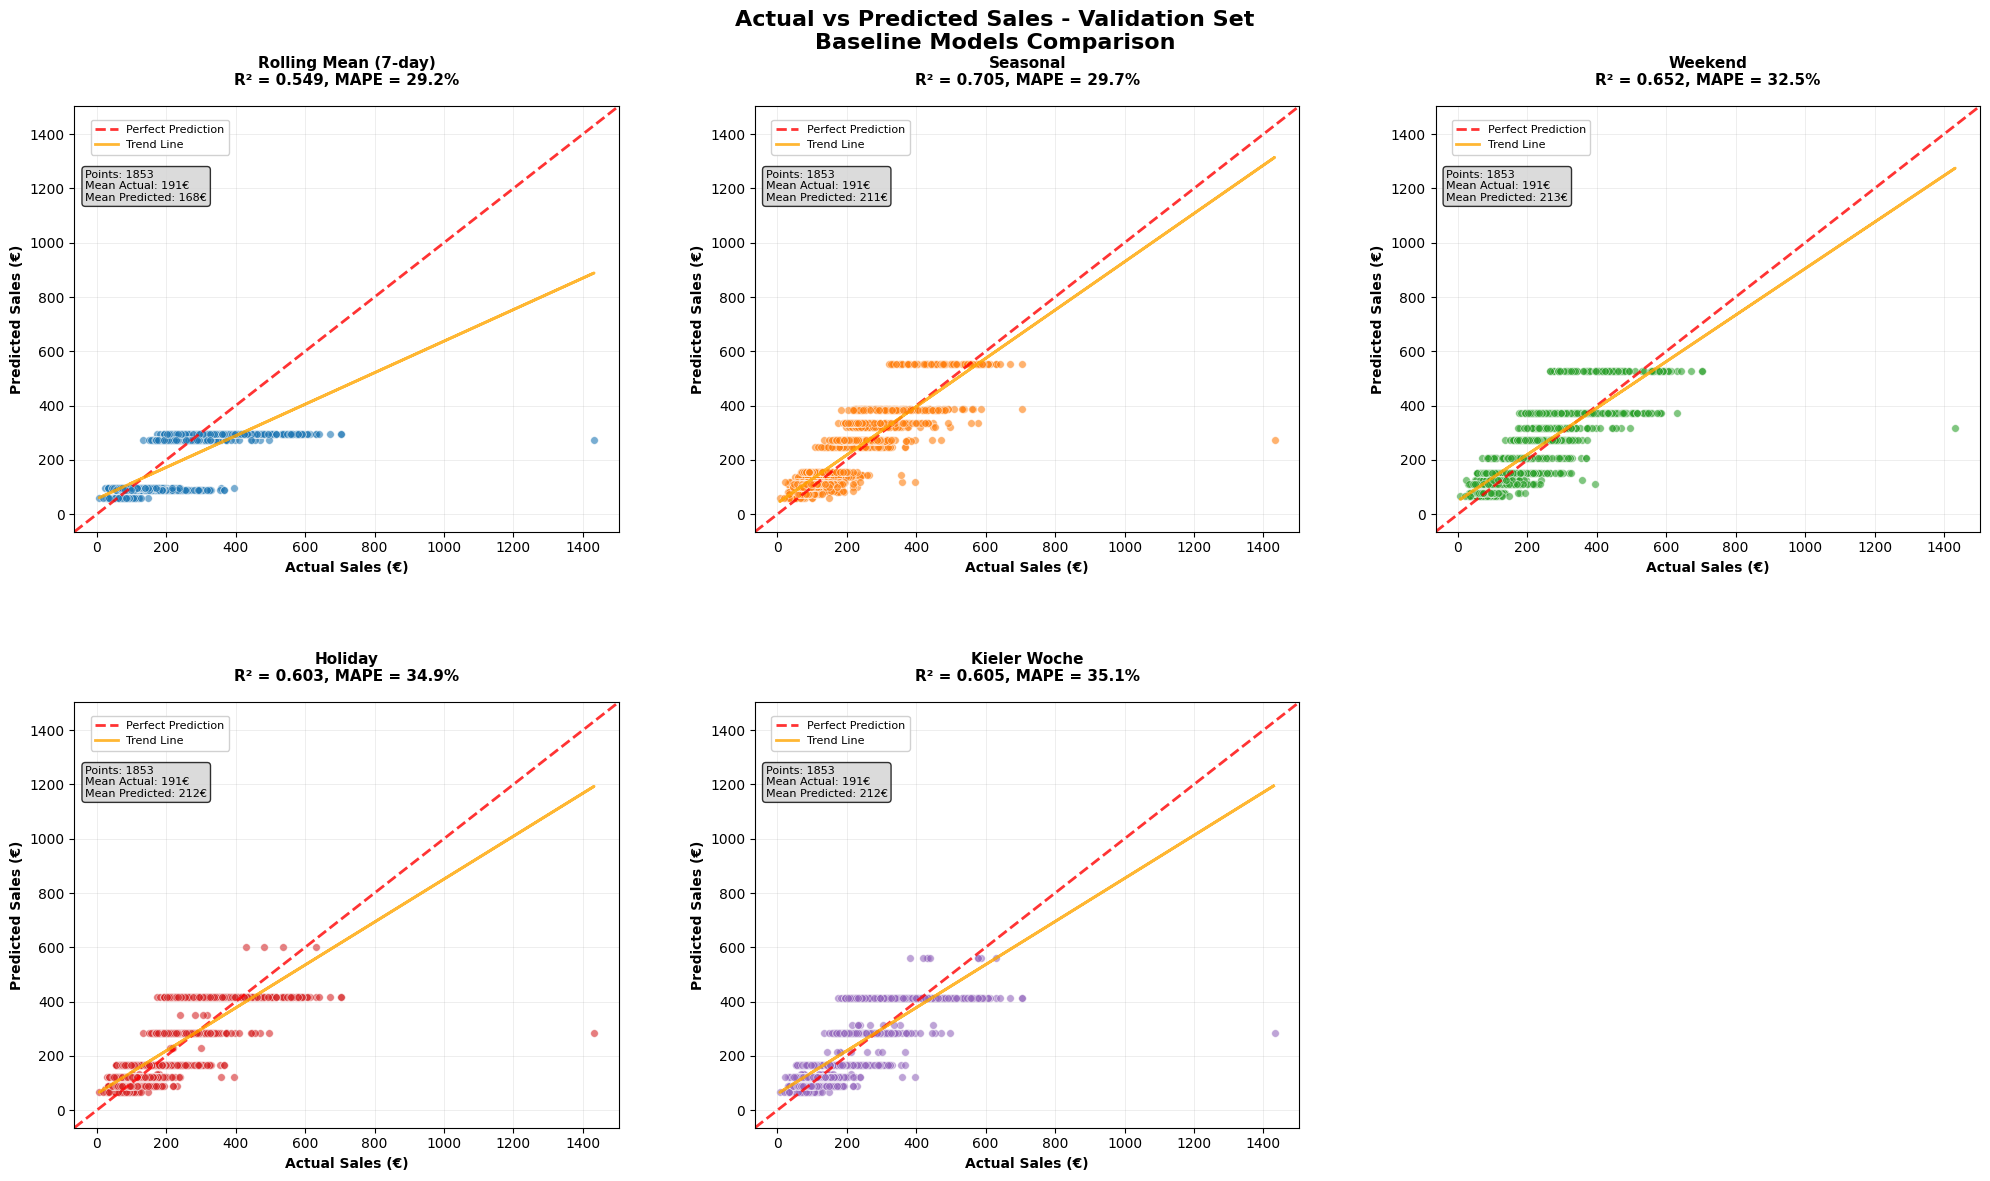


2. Creating Actual vs Predicted plots for Test set...


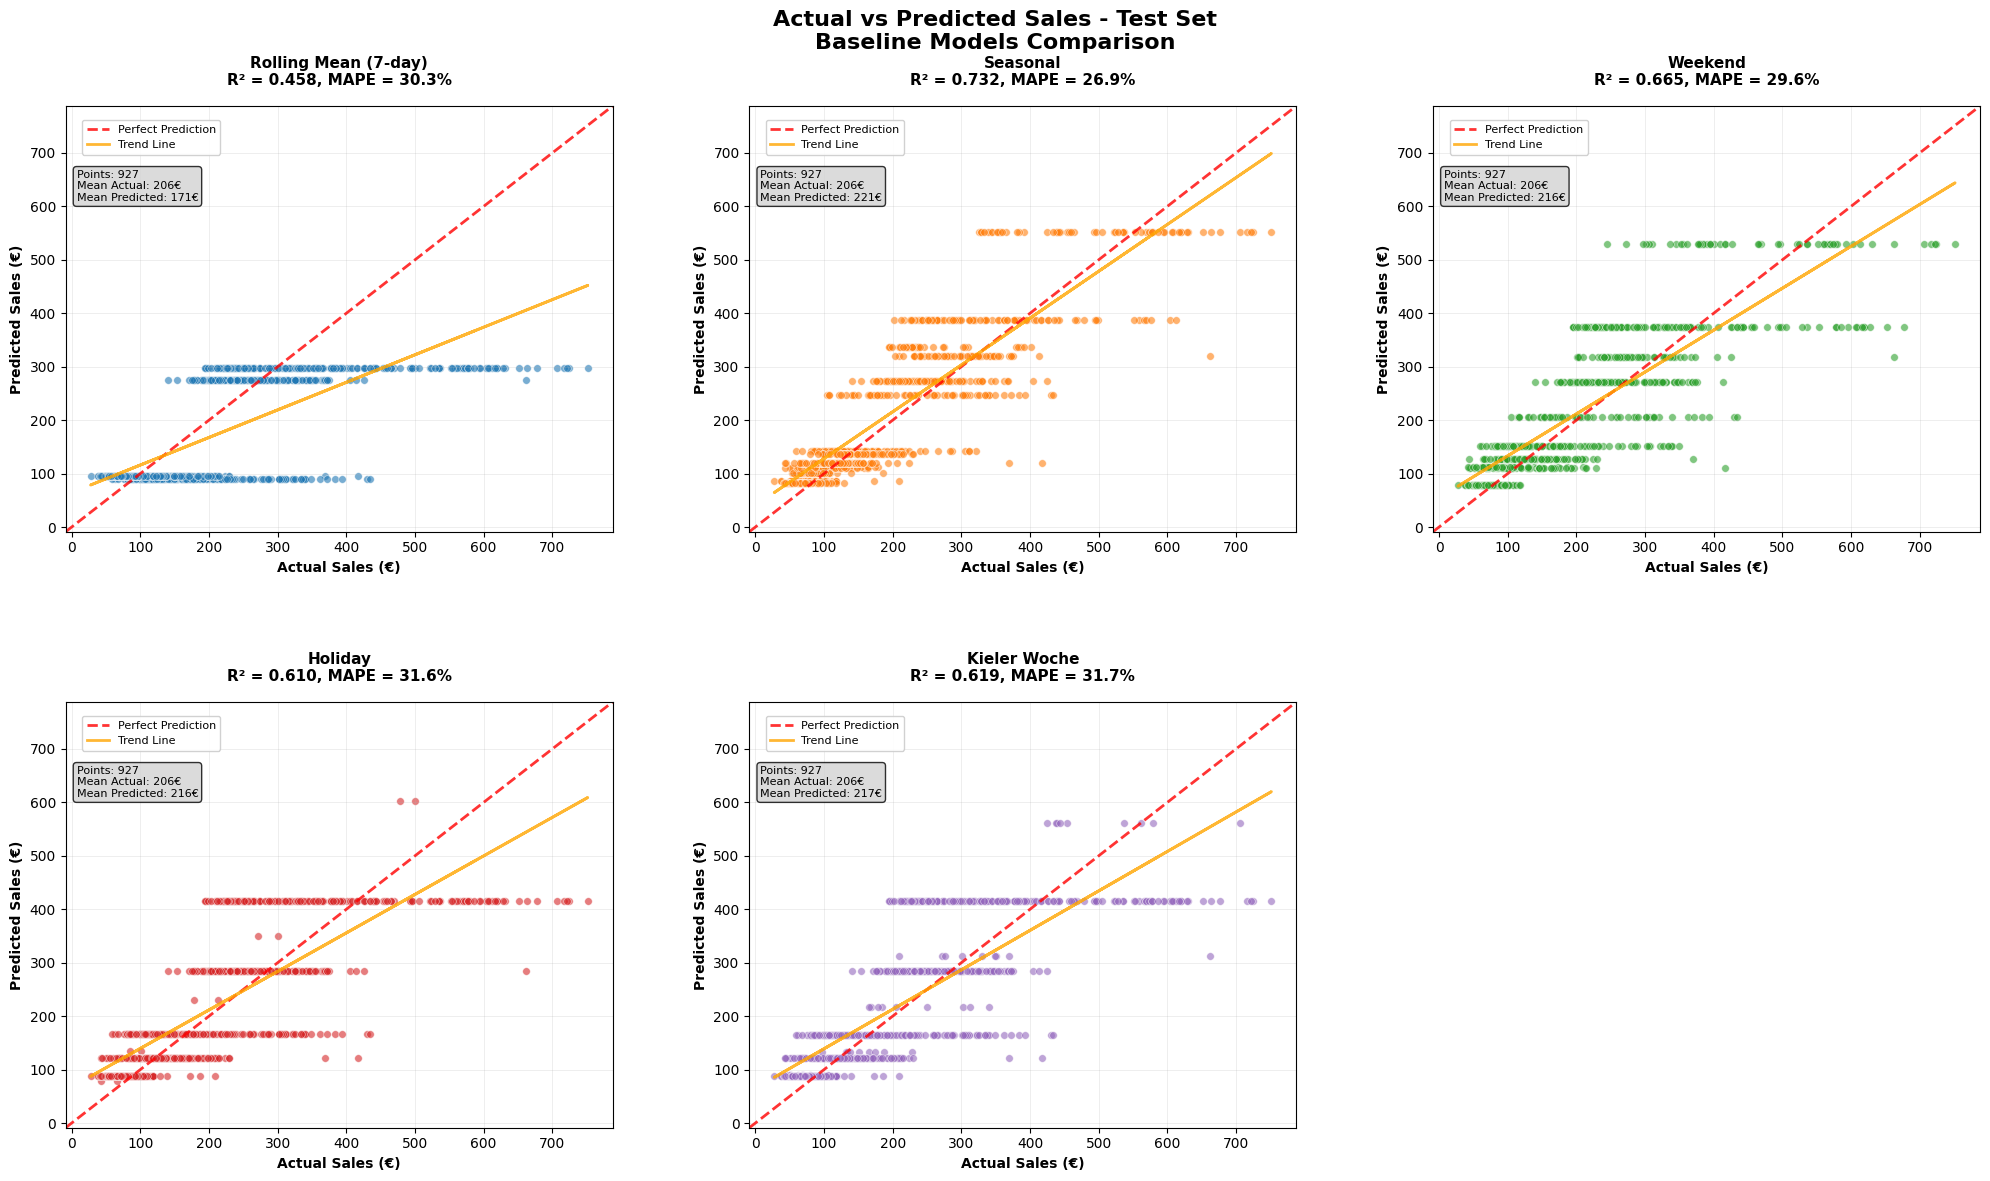


3. Creating Residual plots for Test set...


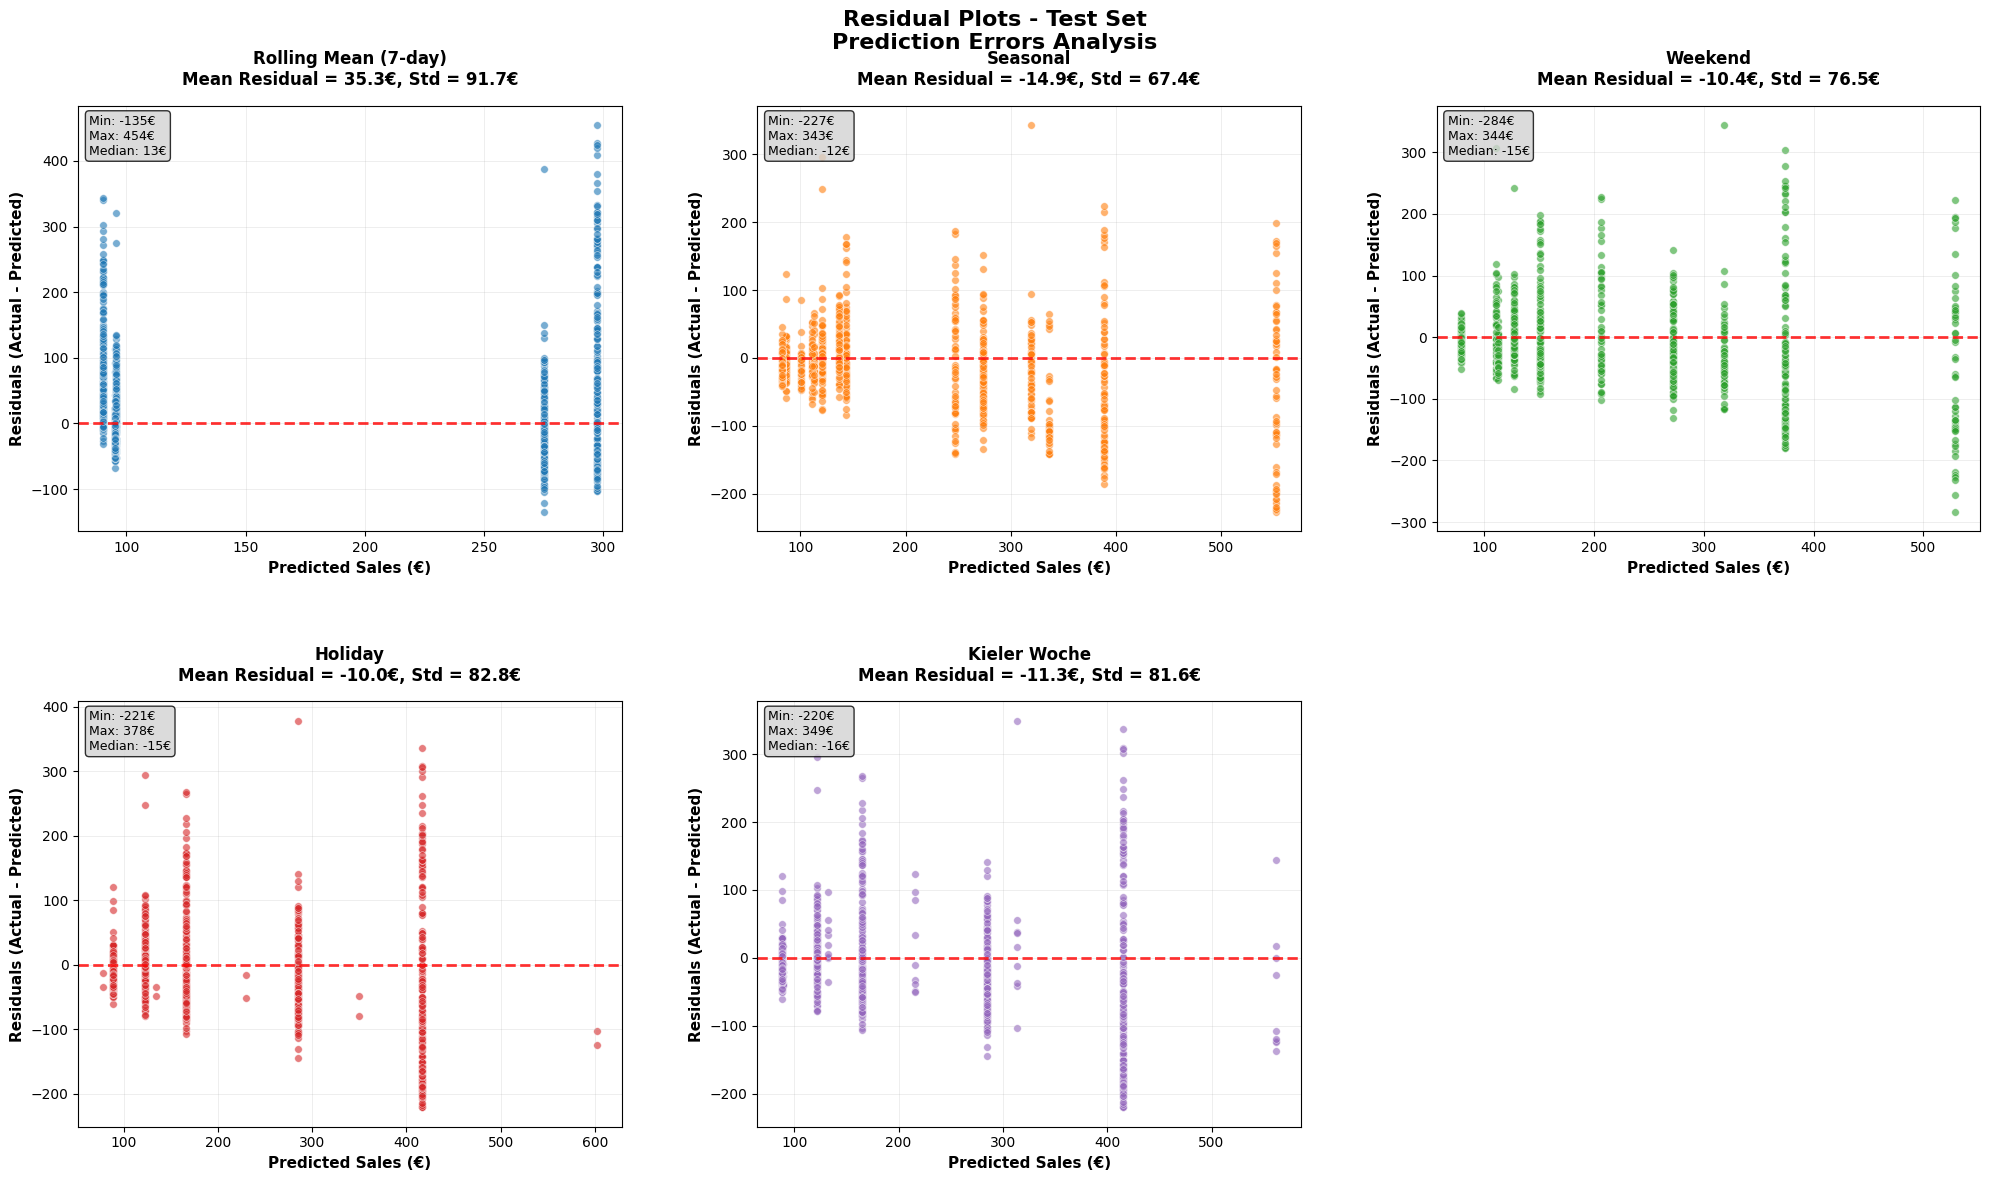


4. Creating Category Performance Heatmap for Test set...


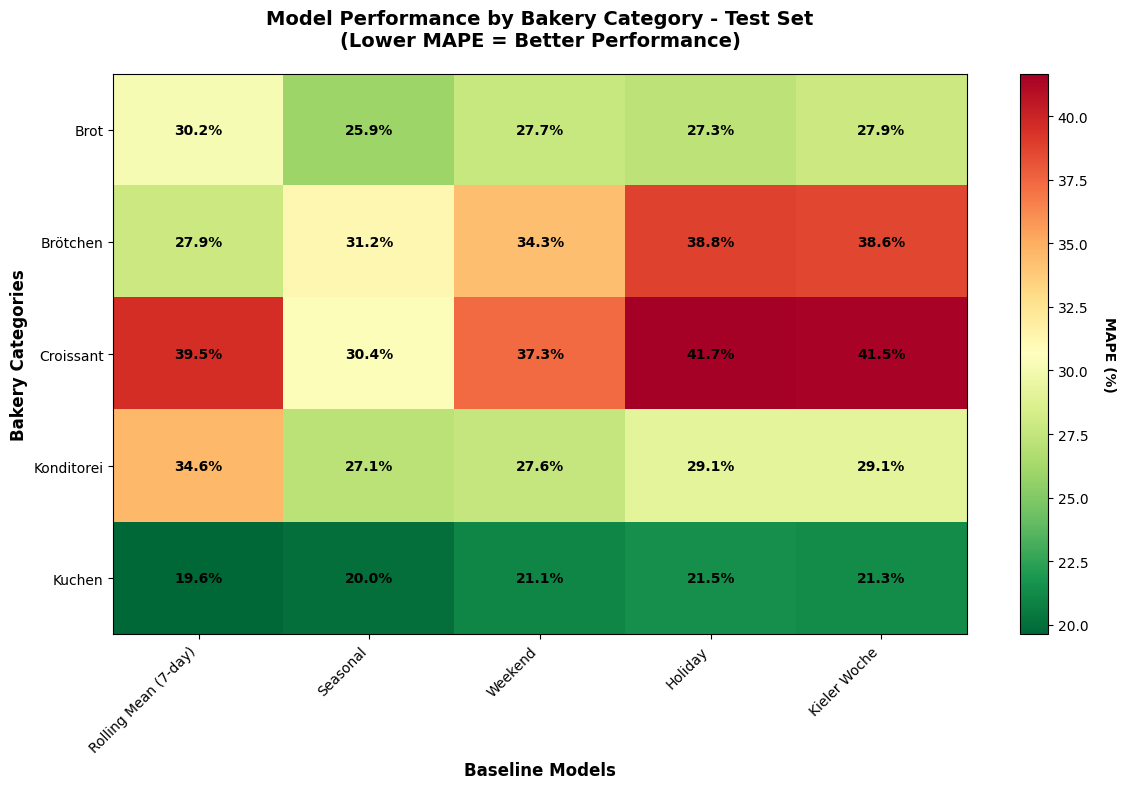


5. Creating Model Performance Summary...


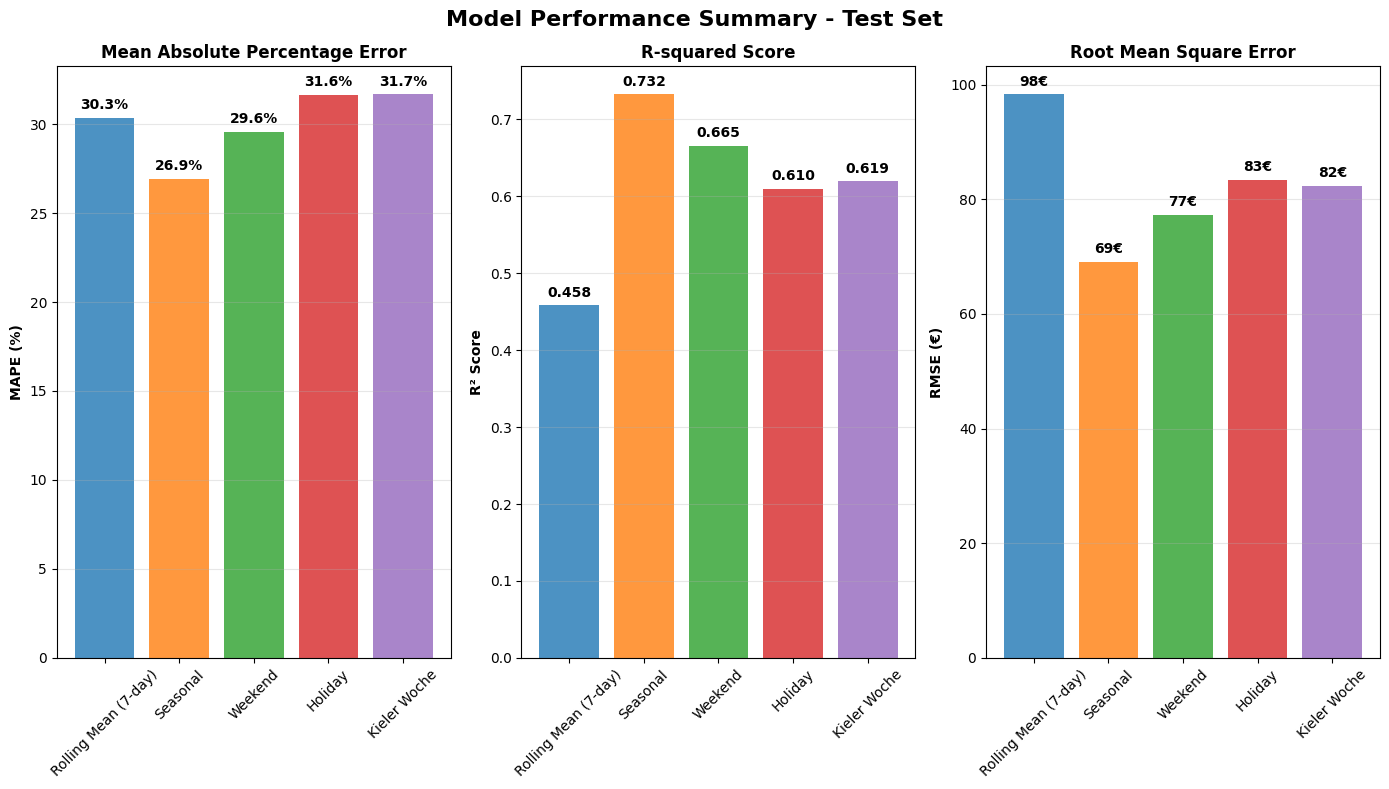


All plots generated successfully!


In [99]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import seaborn as sns

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

def create_actual_vs_predicted_plots(actual_values, predictions_dict, dataset_name="Test", figsize=(20, 12)):
    """
    Create 5 separate plots showing actual vs predicted values for each baseline model
    
    Parameters:
    - actual_values: Array of actual sales values
    - predictions_dict: Dictionary with model names as keys and predictions as values
    - dataset_name: Name of the dataset (e.g., "Test", "Validation")
    - figsize: Figure size tuple
    """
    
    # Create figure with 5 subplots (2 rows, 3 columns, with last subplot removed)
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle(f'Actual vs Predicted Sales - {dataset_name} Set\nBaseline Models Comparison', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Remove the 6th subplot (bottom right)
    fig.delaxes(axes[1, 2])
    
    # Flatten axes for easier iteration
    axes_flat = [axes[0, 0], axes[0, 1], axes[0, 2], axes[1, 0], axes[1, 1]]
    
    # Define colors for each model
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Calculate overall min and max for consistent axis scaling
    all_values = list(actual_values) + [pred for preds in predictions_dict.values() for pred in preds]
    min_val = min(all_values)
    max_val = max(all_values)
    axis_margin = (max_val - min_val) * 0.05  # 5% margin
    
    for i, (model_name, predictions) in enumerate(predictions_dict.items()):
        ax = axes_flat[i]
        
        # Create scatter plot
        ax.scatter(actual_values, predictions, alpha=0.6, s=30, color=colors[i], edgecolors='white', linewidth=0.5)
        
        # Add perfect prediction line (diagonal)
        ax.plot([min_val - axis_margin, max_val + axis_margin], 
                [min_val - axis_margin, max_val + axis_margin], 
                'r--', linewidth=2, alpha=0.8, label='Perfect Prediction')
        
        # Calculate and add trend line
        z = np.polyfit(actual_values, predictions, 1)
        p = np.poly1d(z)
        ax.plot(actual_values, p(actual_values), color='orange', linewidth=2, alpha=0.8, label='Trend Line')
        
        # Calculate metrics for annotation
        r2 = r2_score(actual_values, predictions)
        mape = np.mean(np.abs((actual_values - predictions) / np.where(actual_values != 0, actual_values, 1))) * 100
        
        # Set labels and title
        ax.set_xlabel('Actual Sales (€)', fontsize=10, fontweight='bold')
        ax.set_ylabel('Predicted Sales (€)', fontsize=10, fontweight='bold')
        ax.set_title(f'{model_name}\nR² = {r2:.3f}, MAPE = {mape:.1f}%', 
                    fontsize=11, fontweight='bold', pad=15)
        
        # Set consistent axis limits
        ax.set_xlim(min_val - axis_margin, max_val + axis_margin)
        ax.set_ylim(min_val - axis_margin, max_val + axis_margin)
        
        # Add grid
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        
        # Add legend
        ax.legend(loc='upper left', fontsize=8, framealpha=0.9, bbox_to_anchor=(0.02, 0.98))
        
        # Add statistics text box with better positioning (upper left, below legend area)
        stats_text = f'Points: {len(actual_values)}\nMean Actual: {np.mean(actual_values):.0f}€\nMean Predicted: {np.mean(predictions):.0f}€'
        ax.text(0.02, 0.85, stats_text, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        
    # Add main title with proper spacing - positioned outside subplots
    fig.suptitle(f'Actual vs Predicted Sales - {dataset_name} Set\nBaseline Models Comparison', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    
    # Adjust layout with more spacing to accommodate title
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, hspace=0.4, wspace=0.25)
    
    return fig

def create_residual_plots(actual_values, predictions_dict, dataset_name="Test", figsize=(20, 12)):
    """
    Create residual plots to show prediction errors for each model
    """
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle(f'Residual Plots - {dataset_name} Set\nPrediction Errors Analysis', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Remove the 6th subplot
    fig.delaxes(axes[1, 2])
    axes_flat = [axes[0, 0], axes[0, 1], axes[0, 2], axes[1, 0], axes[1, 1]]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, (model_name, predictions) in enumerate(predictions_dict.items()):
        ax = axes_flat[i]
        
        # Calculate residuals
        residuals = actual_values - predictions
        
        # Create residual plot
        ax.scatter(predictions, residuals, alpha=0.6, s=30, color=colors[i], edgecolors='white', linewidth=0.5)
        
        # Add horizontal line at y=0
        ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.8)
        
        # Calculate statistics
        mean_residual = np.mean(residuals)
        std_residual = np.std(residuals)
        
        # Set labels and title
        ax.set_xlabel('Predicted Sales (€)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Residuals (Actual - Predicted)', fontsize=11, fontweight='bold')
        ax.set_title(f'{model_name}\nMean Residual = {mean_residual:.1f}€, Std = {std_residual:.1f}€', 
                    fontsize=12, fontweight='bold', pad=15)
        
        # Add grid
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        
        # Add statistics text box
        stats_text = f'Min: {np.min(residuals):.0f}€\nMax: {np.max(residuals):.0f}€\nMedian: {np.median(residuals):.0f}€'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    # Adjust layout with more spacing to accommodate title
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, hspace=0.4, wspace=0.25)
    
    return fig


def create_category_performance_heatmap(cat_results_dict, dataset_name="Test", figsize=(12, 8)):
    """
    Create heatmap showing MAPE performance by category and model
    """
    
    if not cat_results_dict:
        print(f"No category results available for {dataset_name} set")
        return None
    
    # Create MAPE matrix
    mape_data = []
    categories_list = []
    models_list = list(next(iter(cat_results_dict.values())).keys())
    
    for category, model_results in cat_results_dict.items():
        category_mapes = []
        for model in models_list:
            mape = model_results[model]['MAPE']
            if np.isnan(mape) or np.isinf(mape):
                mape = 999  # High value for missing/invalid data
            category_mapes.append(mape)
        mape_data.append(category_mapes)
        categories_list.append(category_names[category])
    
    # Create DataFrame for heatmap
    mape_df = pd.DataFrame(mape_data, columns=models_list, index=categories_list)
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap with custom colormap
    im = ax.imshow(mape_df.values, cmap='RdYlGn_r', aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(models_list)))
    ax.set_yticks(np.arange(len(categories_list)))
    ax.set_xticklabels(models_list, rotation=45, ha='right')
    ax.set_yticklabels(categories_list)
    
    # Add text annotations
    for i in range(len(categories_list)):
        for j in range(len(models_list)):
            value = mape_df.iloc[i, j]
            color = 'white' if value > 100 else 'black'
            text = f'{value:.1f}%' if value < 999 else 'N/A'
            ax.text(j, i, text, ha='center', va='center', color=color, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('MAPE (%)', rotation=270, labelpad=20, fontweight='bold')
    
    # Set title and labels
    ax.set_title(f'Model Performance by Bakery Category - {dataset_name} Set\n(Lower MAPE = Better Performance)', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Baseline Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Bakery Categories', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    return fig

# Main plotting function
def plot_all_comparisons(actual_val, predictions_val, actual_test, predictions_test, cat_val_results, cat_test_results):
    """
    Generate all comparison plots
    """
    
    print("Generating comprehensive comparison plots...")
    print("="*60)
    
    # 1. Actual vs Predicted - Validation Set
    print("1. Creating Actual vs Predicted plots for Validation set...")
    fig1 = create_actual_vs_predicted_plots(actual_val, predictions_val, "Validation")
    plt.show()
    
    # 2. Actual vs Predicted - Test Set
    print("\n2. Creating Actual vs Predicted plots for Test set...")
    fig2 = create_actual_vs_predicted_plots(actual_test, predictions_test, "Test")
    plt.show()
    
    # 3. Residual Plots - Test Set
    print("\n3. Creating Residual plots for Test set...")
    fig3 = create_residual_plots(actual_test, predictions_test, "Test")
    plt.show()
    
    # 4. Category Performance Heatmap - Test Set
    print("\n4. Creating Category Performance Heatmap for Test set...")
    fig4 = create_category_performance_heatmap(cat_test_results, "Test")
    if fig4:
        plt.show()
    
    # 5. Model Performance Summary Bar Chart
    print("\n5. Creating Model Performance Summary...")
    create_performance_summary_chart(actual_test, predictions_test)
    
    print("\nAll plots generated successfully!")

def create_performance_summary_chart(actual_values, predictions_dict, figsize=(14, 8)):
    """
    Create summary bar chart showing key metrics for all models
    """
    
    metrics_data = {
        'Model': [],
        'MAPE': [],
        'R²': [],
        'RMSE': []
    }
    
    for model_name, predictions in predictions_dict.items():
        r2 = r2_score(actual_values, predictions)
        mape = np.mean(np.abs((actual_values - predictions) / np.where(actual_values != 0, actual_values, 1))) * 100
        rmse = np.sqrt(np.mean((actual_values - predictions) ** 2))
        
        metrics_data['Model'].append(model_name)
        metrics_data['MAPE'].append(mape)
        metrics_data['R²'].append(r2)
        metrics_data['RMSE'].append(rmse)
    
    # Create subplots for different metrics
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle('Model Performance Summary - Test Set', fontsize=16, fontweight='bold')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # MAPE Chart
    bars1 = axes[0].bar(metrics_data['Model'], metrics_data['MAPE'], color=colors, alpha=0.8)
    axes[0].set_title('Mean Absolute Percentage Error', fontweight='bold')
    axes[0].set_ylabel('MAPE (%)', fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars1, metrics_data['MAPE']):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(metrics_data['MAPE'])*0.01,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # R² Chart
    bars2 = axes[1].bar(metrics_data['Model'], metrics_data['R²'], color=colors, alpha=0.8)
    axes[1].set_title('R-squared Score', fontweight='bold')
    axes[1].set_ylabel('R² Score', fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars2, metrics_data['R²']):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(metrics_data['R²'])*0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # RMSE Chart
    bars3 = axes[2].bar(metrics_data['Model'], metrics_data['RMSE'], color=colors, alpha=0.8)
    axes[2].set_title('Root Mean Square Error', fontweight='bold')
    axes[2].set_ylabel('RMSE (€)', fontweight='bold')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars3, metrics_data['RMSE']):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(metrics_data['RMSE'])*0.01,
                    f'{value:.0f}€', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*100)
print("GENERATING VISUALIZATION PLOTS")
print("="*100)

# Generate all comparison plots
plot_all_comparisons(
    actual_val=val_data['Umsatz'].values,
    predictions_val=val_predictions_all,
    actual_test=test_data['Umsatz'].values,
    predictions_test=test_predictions_all,
    cat_val_results=cat_val_results,
    cat_test_results=cat_test_results
)